In [1]:
!pip install numpy torch sympy mod blobfile pandas seaborn matplotlib tqdm einops wandb

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from contextlib import suppress
from dataclasses import dataclass, asdict
from datetime import datetime
from typing import Callable, Literal, Optional, Union, Tuple
from copy import deepcopy

import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import optim
import wandb
from tqdm.notebook import tqdm
import ipywidgets as widgets
import wandb

from grokking.dataset import ModularArithmetic, Operator
from grokking.transformer import Transformer
from grokking.utils import generate_run_name
from grokking.learner import Config, GrokkingLearner

DEFAULT_MODULUS = 113
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


# Unifying Grokking & DD

In [2]:
config = Config(
    lr=1e-3,
    d_model=128,
    weight_decay=1.,
    test_acc_criterion=1.,
    device=DEVICE,  
)

In [3]:
# Dataset

train_dataset, val_dataset = ModularArithmetic.generate_split(
    operator=config.operator,
    modulus=config.modulus,
    frac_label_noise=config.frac_label_noise,
    seed=config.seed,
    shuffle=config.shuffle,
    frac_train=config.frac_train,
)

# Dataloaders

train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size)

In [4]:
# Logging
date_time = datetime.now().strftime("%Y%m%d-%H%M%S-%f")
mode = "disabled" if config.no_logging else None

In [5]:
# Training

def train_test_run():
    learner = GrokkingLearner.create(config, train_dataloader, val_dataloader)

    if config.resume_run_id is None:
        wandb.init(
            project=config.wandb_project,
            id=date_time,
            settings=wandb.Settings(start_method="thread"),
            name=learner.name,
            config=asdict(config),
            mode=mode,
        )
    else:
        wandb.init(
            project=config.wandb_project,
            id=config.resume_run_id,
            resume="must",
            settings=wandb.Settings(start_method="thread"),
            name=learner.name,
            config=asdict(config),
            mode=mode,
        )
    wandb.watch(learner.model)
    
    try: 
        learner.train()
    except KeyboardInterrupt:
        wandb.finish()


train_test_run()

Model has 226816 trainable parameters


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jqhoogland. Use `wandb login --relogin` to force relogin


  0%|          | 0/100000 [00:00<?, ?it/s]

Test accuracy criterion reached


# Sweeps

To initialize a sweep, run the following command:

```shell
wandb sweep --project grokking <config.yml>
```

where `<config.yml>` is the config file you want to use.

To run the sweep, run the following command:

```shell
wandb agent <sweep_id> --function train
```

where `<sweep_id>` is the id of the sweep you want to run. You can find the sweep id by running `wandb sweep ls`.

You can pass an optional `--count` flag to the `wandb agent` command to specify the number of runs you want to execute. If you don't pass this flag, the agent will run until all the runs in the sweep are complete (for a grid sweep).

On a multi-GPU machine, you can run multiple agents in parallel through the following:

```shell
CUDA_VISIBLE_DEVICES=0 wandb agent <sweep_id> &
CUDA_VISIBLE_DEVICES=1 wandb agent <sweep_id> &
...
```

In [11]:
import json
import numpy as np

def generate_coarse_to_fine_grid_sweep(min_, max_, total_steps, step_sizes=[10, 5, 3, 1], type_="log"):
    if type_ == "log":
        # Generate the logscale range
        grid = np.logspace(np.log10(min_), np.log10(max_), total_steps)
    elif type_ == "linear":
        grid = np.linspace(min_, max_, total_steps)
    else:
        grid = np.arange(min_, max_, int((max_ - min_) / total_steps))

    # Initialize an empty list to store the rearranged elements
    rearranged_grid = []

    # Iterate over the step sizes and merge the sublists
    for step in step_sizes:
        for i in range(0, len(grid), step):
            if grid[i] not in rearranged_grid:
                rearranged_grid.append(grid[i])

    return rearranged_grid

## Model-wise

In [14]:
model_grid = generate_coarse_to_fine_grid_sweep(20, 201, 100, step_sizes=[60, 30, 20, 10, 5, 3, 1], type_="range")
print(model_grid)

[20, 80, 140, 200, 50, 110, 170, 40, 60, 100, 120, 160, 180, 30, 70, 90, 130, 150, 190, 25, 35, 45, 55, 65, 75, 85, 95, 105, 115, 125, 135, 145, 155, 165, 175, 185, 195, 23, 26, 29, 32, 38, 41, 44, 47, 53, 56, 59, 62, 68, 71, 74, 77, 83, 86, 89, 92, 98, 101, 104, 107, 113, 116, 119, 122, 128, 131, 134, 137, 143, 146, 149, 152, 158, 161, 164, 167, 173, 176, 179, 182, 188, 191, 194, 197, 21, 22, 24, 27, 28, 31, 33, 34, 36, 37, 39, 42, 43, 46, 48, 49, 51, 52, 54, 57, 58, 61, 63, 64, 66, 67, 69, 72, 73, 76, 78, 79, 81, 82, 84, 87, 88, 91, 93, 94, 96, 97, 99, 102, 103, 106, 108, 109, 111, 112, 114, 117, 118, 121, 123, 124, 126, 127, 129, 132, 133, 136, 138, 139, 141, 142, 144, 147, 148, 151, 153, 154, 156, 157, 159, 162, 163, 166, 168, 169, 171, 172, 174, 177, 178, 181, 183, 184, 186, 187, 189, 192, 193, 196, 198, 199]


## Sample-wise

In [ ]:
frac_train_grid = generate_coarse_to_fine_grid_sweep(0, 1.05, 20, step_sizes=[.5, .2, .1, .05], type_="range")
print(frac_train_grid)

## Regularization-wise

In [1]:
wds = generate_coarse_to_fine_grid_sweep(0.05, 10, 51)
print(json.dumps(wds))

[0.049999999999999996, 0.14426999059072135, 0.41627660370093655, 1.201124433981431, 3.4657242157757318, 10.0, 0.08493232323171235, 0.24506370946974493, 0.7071067811865475, 2.0402857733683692, 5.887040186524747, 0.06871187569715699, 0.09442643723643111, 0.12976435235830103, 0.17832704098331334, 0.3367757428593863, 0.46280985962343724, 0.6360106709172864, 0.87402972324268, 1.6506302560910038, 2.2683580195698294, 3.1172626855466286, 4.283859323293314, 8.090191470413135, 0.05558922306812267, 0.06180323442635004, 0.07639279571116754, 0.10498184566128109, 0.1167171847313636, 0.16039713377967135, 0.19826123320599312, 0.22042375836898087, 0.27245802423230514, 0.3029145977149917, 0.37442203787486295, 0.5145448104946759, 0.572062924982669, 0.7861503318472239, 0.9717326650701373, 1.0803572776233041, 1.3353914818633272, 1.484667499371428, 1.8351450701767056, 2.5219251989646447, 2.803837248927306, 3.8531383304670337, 4.7627282303001826, 5.29512724014004, 6.545119802794536, 7.2767624945026474, 8.994

In [165]:
api = wandb.Api()

sweep = api.sweep("jqhoogland/grokking/2peyz0vr")
sweep_runs = sweep.runs

def create_run_df(history, config):
    for k, v in config.items():
        if k == 'momentum' and isinstance(v, list):
            v = [tuple(v)] * len(history)
        history[k] = v

    return history

# [run.config for run in sweep_runs]
reg_sweep_history = pd.concat([create_run_df(run.history(), run.config) for run in sweep_runs])

,weight/cos_sim_with_init,gradients/blocks.0.attn.W_K,gradients/blocks.0.attn.W_Q,gradients/blocks.0.attn.W_V,_step,train/acc,_timestamp,weight/norm,gradients/blocks.0.mlp.b_in,gradients/blocks.0.mlp.W_out,...,num_layers,weights_dir,log_interval,weight_decay,resume_run_id,wandb_project,frac_label_noise,num_training_steps,test_acc_criterion,log_normalized_loss
0,0.101520,None,None,None,69860.0,1.0,1.683104e+09,29.203423,None,None,...,1,weights,10,0.78615,None,grokking,0,100000,1.00,True
1,0.103120,None,None,None,61410.0,1.0,1.683103e+09,29.207294,None,None,...,1,weights,10,0.78615,None,grokking,0,100000,1.00,True
2,0.120518,None,None,None,23210.0,1.0,1.683100e+09,29.379549,None,None,...,1,weights,10,0.78615,None,grokking,0,100000,1.00,True
3,0.098228,None,None,None,92930.0,1.0,1.683106e+09,29.199954,None,None,...,1,weights,10,0.78615,None,grokking,0,100000,1.00,True
4,0.099647,None,None,None,82170.0,1.0,1.683105e+09,29.200771,None,None,...,1,weights,10,0.78615,None,grokking,0,100000,1.00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.632268,None,None,None,21040.0,1.0,1.682191e+09,57.863626,None,None,...,1,weights,10,0.05000,None,grokking,0,100000,0.99,True
496,0.662909,None,None,None,16830.0,1.0,1.682190e+09,59.124939,None,None,...,1,weights,10,0.05000,None,grokking,0,100000,0.99,True
497,0.523060,None,None,None,41620.0,1.0,1.682192e+09,54.589726,None,None,...,1,weights,10,0.05000,None,grokking,0,100000,0.99,True
498,0.615211,None,None,None,23580.0,1.0,1.682191e+09,57.261049,None,None,...,1,weights,10,0.05000,None,grokking,0,100000,0.99,True


In [199]:
refined_sweep = api.sweep("jqhoogland/grokking/oxsp97s3")
refined_sweep_runs = refined_sweep.runs

refined_reg_sweep_history = pd.concat([create_run_df(run.history(), run.config) for run in refined_sweep_runs])

# Copy into reg_sweep_history.
# Each row should be unique for a given choice of _step and weight_decay.
# If there are duplicates, the refined_sweep history will overwrite the reg_sweep_history.

reg_sweep_history = pd.concat([reg_sweep_history, refined_reg_sweep_history]).drop_duplicates(['_step', 'weight_decay'], keep='last')
df = reg_sweep_history.copy()
reg_sweep_history

,weight/cos_sim_with_init,_step,train/acc,_timestamp,weight/norm,test/acc,train/efficiency,weight/dist_from_init,train/loss,_runtime,...,shuffle,use_sgd,momentum,operator,load_path,no_logging,weights_dir,resume_run_id,wandb_project,log_normalized_loss
4,0.791108,1030.0,1.0,1.682189e+09,69.746135,0.178991,4.114320e-09,44.584393,2.869579e-07,84.139076,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.787028,1220.0,1.0,1.682189e+09,70.187663,0.181788,8.133661e-10,45.213232,5.708826e-08,99.169848,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.786224,1270.0,1.0,1.682189e+09,70.243886,0.182123,5.935314e-10,45.311845,4.169195e-08,103.010672,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.783294,1530.0,1.0,1.682189e+09,70.218350,0.182906,2.415810e-10,45.482430,1.696342e-08,123.512322,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.782312,1650.0,1.0,1.682189e+09,70.104020,0.183018,2.089196e-10,45.453107,1.464610e-08,133.018361,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,0.792583,975.0,1.0,1.683208e+09,69.559036,0.177425,7.187933e-09,44.334388,4.999857e-07,102.299487,...,True,False,"(0.9, 0.98)",+,None,False,weights,None,grokking,True
276,0.792444,980.0,1.0,1.683208e+09,69.576950,0.177649,6.824988e-09,44.358182,4.748619e-07,102.721539,...,True,False,"(0.9, 0.98)",+,None,False,weights,None,grokking,True
277,0.792306,985.0,1.0,1.683208e+09,69.594689,0.177760,6.481638e-09,44.381767,4.510876e-07,103.150825,...,True,False,"(0.9, 0.98)",+,None,False,weights,None,grokking,True
278,0.792169,990.0,1.0,1.683208e+09,69.612250,0.177872,6.156961e-09,44.405142,4.285999e-07,103.690468,...,True,False,"(0.9, 0.98)",+,None,False,weights,None,grokking,True


In [203]:
reg_sweep_history = df.copy()
df = reg_sweep_history.copy()

# ignore weight_decay > 5.
# reg_sweep_history = reg_sweep_history[reg_sweep_history.weight_decay <= 5.]
# find the weight decays whose "train/loss" exceeds 10^-3 past "_step=1000"
outlier_wds = reg_sweep_history.loc[(reg_sweep_history._step >= 1000) & (reg_sweep_history["train/loss"] > 1e-3), :].loc[:, "weight_decay"].unique()

# remove these outliers
reg_sweep_history = reg_sweep_history[~reg_sweep_history.weight_decay.isin(outlier_wds)]


# Find the weight decays who don't have any steps past 1000
all_wds = reg_sweep_history.loc[:, "weight_decay"].unique()
completed_wds = reg_sweep_history.loc[reg_sweep_history._step > 1000, :].loc[:, "weight_decay"].unique()
incomplete_wds = set(all_wds) - set(completed_wds)

# remove these incomplete runs
reg_sweep_history = reg_sweep_history[~reg_sweep_history.weight_decay.isin(incomplete_wds)]

# Find the earliest entry with a valid "train/loss", "test/loss", etc.
# Copy this value to any other runs (each run is identified by the weight decay value) 
# that do not have a valid value for the metrics at this earliest step

# Find the earliest step with a valid "train/loss"
# earliest_valid_step = 0 # reg_sweep_history.loc[reg_sweep_history["train/loss"].notnull(), :].loc[:, "_step"].min()
# earliest_rows = reg_sweep_history.loc[reg_sweep_history["_step"] == earliest_valid_step, :]
# earliest_row = earliest_rows.iloc[0, :]

# valid_wds = earliest_rows.loc[:, "weight_decay"].unique()
# invalid_wds = reg_sweep_history.loc[~reg_sweep_history.weight_decay.isin(valid_wds), :].loc[:, "weight_decay"].unique()

# # print("Valid", valid_wds)
# # print("Invalid", invalid_wds)

# new_rows = []

# for wd in invalid_wds:
#     new_row = earliest_row.copy().to_frame().T
#     new_row["weight_decay"] = wd
#     new_rows.append(new_row)

# new_rows = pd.concat(new_rows)

# reg_sweep_history = pd.concat([reg_sweep_history, new_rows])
reg_sweep_history = reg_sweep_history.sort_values(by=["weight_decay", "_step"])

# if the "train/loss" or any other metric is NaN after a certain step, 
# then we should set every metric after that step to the last valid value
# reg_sweep_history = reg_sweep_history.groupby('weight_decay').apply(lambda group: group.fillna(method='bfill'))

# Reset the index after applying the groupby operation
reg_sweep_history.reset_index(drop=True, inplace=True)

# reg_sweep_history.loc[reg_sweep_history._step == 0, ["_step", "weight_decay", "train/loss", "test/loss", "train/acc", "test/acc"]]
# for wd in invalid_wds:
    # print(reg_sweep_history.loc[reg_sweep_history.weight_decay == wd, ["_step", "weight_decay", "train/loss", "test/loss", "train/acc", "test/acc"]].iloc[:5, :])

# Change step 0 to 1
reg_sweep_history.loc[reg_sweep_history._step == 0, "_step"] = 1

# Convert numpy types to native python types
reg_sweep_history = reg_sweep_history.applymap(lambda x: x.item() if isinstance(x, np.generic) else x)

# Drop non-numeric columns
print(reg_sweep_history.dtypes)
non_numeric_columns = reg_sweep_history.select_dtypes(exclude=['int', 'float', 'int64', 'float64']).columns
reg_sweep_history = reg_sweep_history.drop(columns=non_numeric_columns)
reg_sweep_history

weight/cos_sim_with_init        float64
_step                           float64
train/acc                       float64
_timestamp                      float64
weight/norm                     float64
test/acc                        float64
train/efficiency                float64
weight/dist_from_init           float64
train/loss                      float64
_runtime                        float64
test/loss                       float64
test/efficiency                 float64
lr                              float64
seed                              int64
d_mlp                             int64
d_head                            int64
d_model                           int64
d_vocab                           int64
modulus                           int64
num_ctx                           int64
num_heads                         int64
batch_size                        int64
frac_train                      float64
num_layers                        int64
log_interval                      int64


,weight/cos_sim_with_init,_step,train/acc,_timestamp,weight/norm,test/acc,train/efficiency,weight/dist_from_init,train/loss,_runtime,...,batch_size,frac_train,num_layers,log_interval,weight_decay,frac_label_noise,num_training_steps,test_acc_criterion,load_path,resume_run_id
0,1.000000,1.0,0.006005,1.683208e+09,42.226231,0.010292,1.129869e-01,0.000000,4.771011,3.037576,...,3830,0.3,1,5,0.05000,0,1000,1.0,NaN,NaN
1,0.999943,1.0,0.010444,1.683208e+09,42.216228,0.010180,1.123148e-01,0.452837,4.741508,3.294858,...,3830,0.3,1,5,0.05000,0,1000,1.0,NaN,NaN
2,0.999811,2.0,0.010183,1.683208e+09,42.212441,0.009733,1.120153e-01,0.821643,4.728439,3.433418,...,3830,0.3,1,5,0.05000,0,1000,1.0,NaN,NaN
3,0.999631,3.0,0.009661,1.683208e+09,42.213259,0.008614,1.118488e-01,1.147215,4.721503,3.668975,...,3830,0.3,1,5,0.05000,0,1000,1.0,NaN,NaN
4,0.999421,4.0,0.011227,1.683208e+09,42.217321,0.009285,1.117109e-01,1.437315,4.716135,3.912602,...,3830,0.3,1,5,0.05000,0,1000,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25563,0.065940,98540.0,1.000000,1.682721e+09,28.911956,1.000000,3.553437e-08,49.577716,0.000001,8112.537651,...,3830,0.3,1,10,5.88704,0,100000,1.0,NaN,NaN
25564,0.065940,98640.0,1.000000,1.682721e+09,28.912009,1.000000,3.553274e-08,49.577763,0.000001,8120.328687,...,3830,0.3,1,10,5.88704,0,100000,1.0,NaN,NaN
25565,0.065934,99100.0,1.000000,1.682721e+09,28.912046,1.000000,3.553063e-08,49.577913,0.000001,8156.777699,...,3830,0.3,1,10,5.88704,0,100000,1.0,NaN,NaN
25566,0.065934,99130.0,1.000000,1.682721e+09,28.912028,1.000000,3.553064e-08,49.577917,0.000001,8159.157911,...,3830,0.3,1,10,5.88704,0,100000,1.0,NaN,NaN


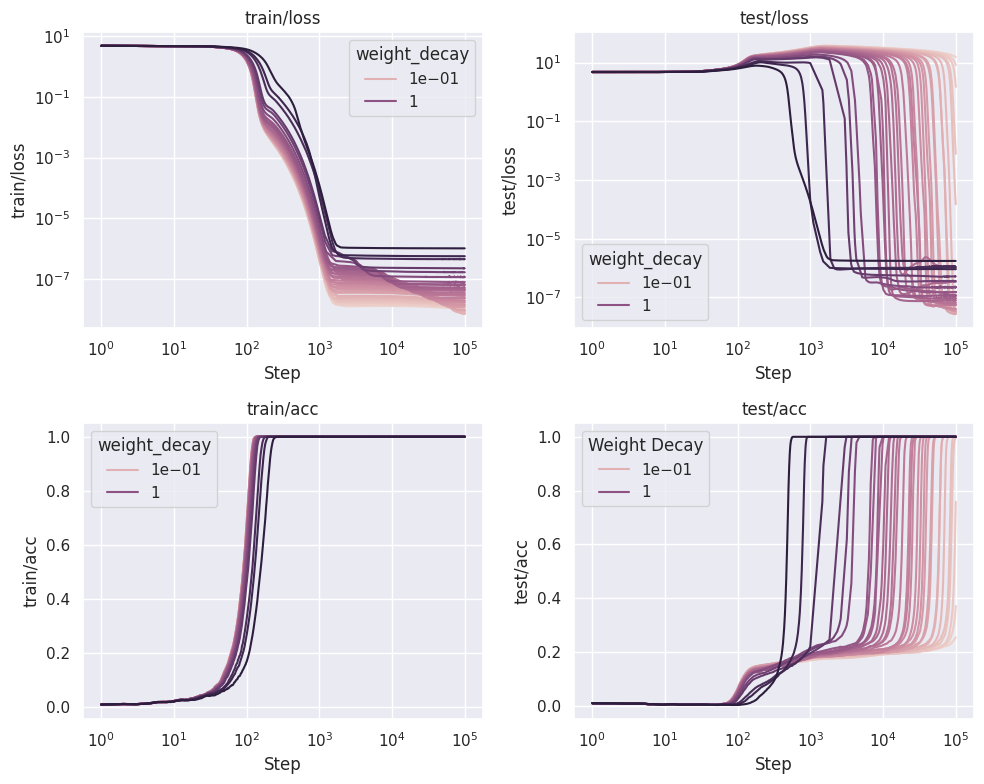

In [205]:
# Plot the learning curves [(_step, "train/loss")], [(_step, "test/loss")], [(_step, "train/acc")], [(_step, "test/acc")]
# for each value of "weight_decay". Use the "hue" argument to color the lines by "weight_decay".

from matplotlib.colors import LogNorm
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

# Set up the subplot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Define the columns to plot
columns = [("_step", "train/loss"), ("_step", "test/loss"), 
           ("_step", "train/acc"), ("_step", "test/acc")]

# Loop through each column and plot the learning curve
for i, column in enumerate(columns):
    row = i // 2
    col = i % 2
    ax = axes[row][col]
    sns.lineplot(data=reg_sweep_history, x=column[0], y=column[1], hue="weight_decay", hue_norm=LogNorm(),  ax=ax)
    ax.set_title(column[1])
    ax.set_xscale('log')
    ax.set_xlabel("Step")
    ax.set_ylabel(column[1])

    if "loss" in column[1]:
        ax.set_yscale('log')

# Add a legend to the last subplot
axes[1][1].legend(title="Weight Decay")
    
# Adjust the layout of the subplots
fig.tight_layout()

In [206]:
import numpy as np 

from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter1d

# Define the columns to plot
columns = ["train/loss", "test/loss", "train/acc", "test/acc"]

# Create a pivot table with the data
pivot_table = pd.pivot_table(reg_sweep_history, values=columns, index="_step", columns="weight_decay")

# Fill in the missing values using linear interpolation and gaussian smoothing
pivot_table = pivot_table.reindex(np.arange(reg_sweep_history._step.min(), reg_sweep_history._step.max()+1))

# This will be used to fill in the missing values for the first few steps
pivot_table = pivot_table.interpolate(method="linear")

# for column in columns:
#     for wd in reg_sweep_history["weight_decay"].unique():
#         col_name = column[1] + " (" + str(wd) + ")"
#         col_data = pivot_table[column][wd].interpolate(method="linear")
#         col_data = gaussian_filter1d(col_data, sigma=1.0)
#         pivot_table[col_name] = col_data

/tmp/ipykernel_245271/1845385037.py:4: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


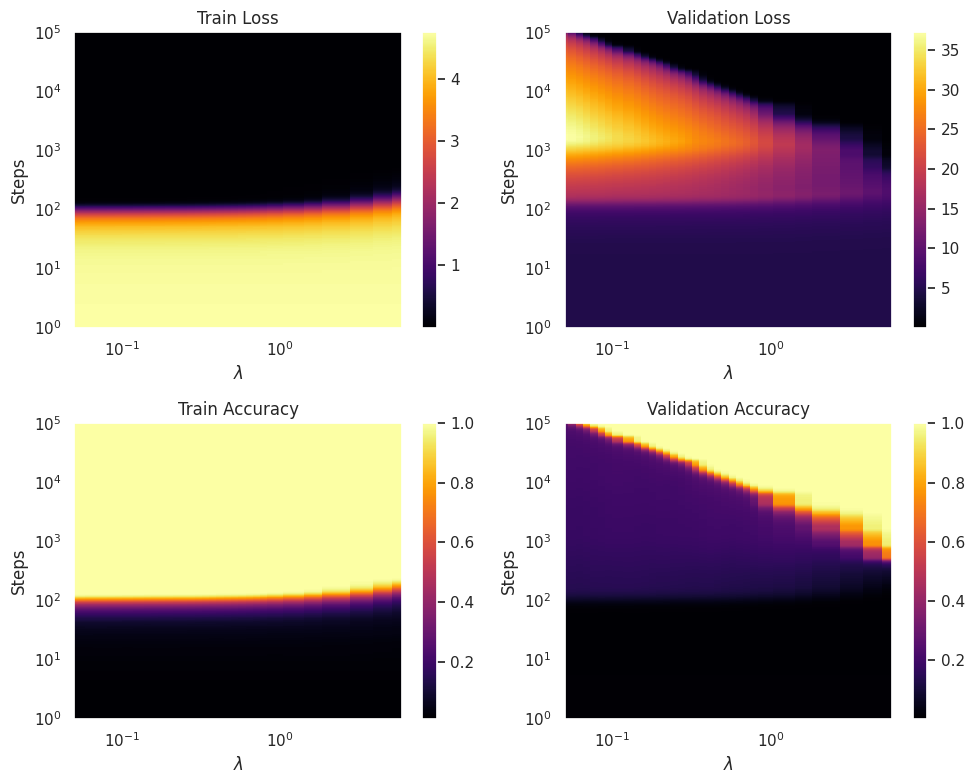

In [216]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
from scipy.ndimage import gaussian_filter

def plot(smooth=True, log_loss=True, cmap="inferno", titles: Optional[dict]=None):
    # Set up the subplot
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

    wds = reg_sweep_history["weight_decay"].unique()
    # Loop through each column and plot the heatmap
    for i, column in enumerate(columns):
        row = i // 2
        col = i % 2
        ax = axes[row][col]

        # Create a meshgrid for the x and y edges
        X, Y = np.meshgrid(wds, pivot_table[column].index)

        # Apply a Gaussian filter

        data = pivot_table[column].values
        
        if smooth:
            data = gaussian_filter(pivot_table[column].values, sigma=1)

        if "loss" in column and log_loss:
            mesh = ax.pcolormesh(X, Y, data, cmap=cmap, norm=LogNorm())
        else:
            mesh = ax.pcolormesh(X, Y, data, cmap=cmap)

        title = titles.get(column, column) if titles else column
        ax.set_title(title)
        ax.set_xlabel("$\\lambda$")
        ax.set_ylabel("Steps")
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_ylim(reg_sweep_history._step.max(), reg_sweep_history._step.min())
        ax.set_yticks([1, 10, 100, 1000, 10000, 100000])
        ax.set_xlim(wds[0], wds[-1])
        ax.invert_yaxis()
        
        # Add a colorbar to each subplot
        fig.colorbar(mesh, ax=ax)

    # Adjust the layout of the subplots
    fig.tight_layout()


plot(smooth=True, log_loss=False, titles = {
    "train/loss": "Train Loss",
    "test/loss": "Validation Loss",
    "train/acc": "Train Accuracy",
    "test/acc": "Validation Accuracy"
})

## Interpolation

In [3]:
# import cifar10    
from typing import List
from torch.utils.data import Subset, Dataset
from torchvision.datasets import MNIST, CIFAR10, VisionDataset
from torchvision import transforms

from grokking.learner import BaseLearner, Reduction

class ExtModule(nn.Module):
    def __init__(self, init_scale: float = 1., init_mode: Literal["uniform", "normal"]="uniform", **kwargs):
        super().__init__(**kwargs)

        self.init_scale = init_scale
        self.init_mode = init_mode

    def init_weights(self):
        for p in self.parameters():
            # if self.init_mode == "uniform":
            #     nn.init.kaiming_uniform_(p.data, a=0, mode='fan_in', nonlinearity='relu')
            # else:
            #     nn.init.kaiming_normal_(p.data, a=0, mode='fan_in', nonlinearity='relu')

            p.data *= self.init_scale

@dataclass
class VisionConfig(Config):
    init_scale: float = 1.
    init_mode: Literal["uniform", "normal"] = "uniform"

    # Dataset
    frac_train: float = 0.2
    frac_label_noise: float = 0.0
     

class VisionLearner(BaseLearner):
    Config = VisionConfig
    Dataset = Union[VisionDataset, Subset[VisionDataset]]


    @classmethod
    def create(
        cls,
        config: Config,
        trainset: Dataset,
        testset: Dataset,
    ) -> "BaseLearner":
        torch.manual_seed(config.seed)
        model = cls.get_model(config)
        optimizer = cls.get_optimizer(config, model)
        trainloader = cls.get_loader(config, trainset)
        testloader = cls.get_loader(config, testset, train=False)
        return cls(model, optimizer, config, trainloader, testloader)

    @staticmethod
    def get_loader(config: Config, dataset: Dataset, train=True) -> DataLoader[Dataset]:
        if train and config.frac_train < 1.0:
            indices = torch.randperm(len(dataset))[:int(len(dataset) * config.frac_train)].tolist()
            dataset = Subset(dataset, indices)

        def add_label_noise(dataset: VisionLearner.Dataset, frac_label_noise: float) -> VisionLearner.Dataset:
            num_samples = len(dataset)
            num_errors = int(num_samples * frac_label_noise)
            
            origin_indices = torch.randperm(num_samples)[:num_errors]
            target_indices = origin_indices.roll(1)

            for origin, target in zip(origin_indices, target_indices):
                dataset.targets[origin] = dataset.targets[target]  # TODO: Make this not in-place

            return dataset

        if config.frac_label_noise > 0.0:
            dataset = add_label_noise(dataset, config.frac_label_noise)

        return DataLoader(
            dataset,
            batch_size=config.batch_size,
            shuffle=train,
        )
    

### Can we recreate grokking on MNIST?

In [4]:
# Normalize & transform to tensors
mnist_train = MNIST(root="../data", train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
]))
mnist_test = MNIST(root="../data", train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
]))
class MLP(ExtModule):
    def __init__(
        self, 
        in_size: int,
        num_layers: int,
        num_classes: int,
        width: int,
        **kwargs
    ):
        super().__init__(**kwargs)
 
        self.in_size = in_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.width = width

        layers: List[nn.Module] = [
            nn.Flatten(),
            nn.Linear(in_size, width),
            nn.ReLU()
        ]

        for _ in range(num_layers - 1):
            layers.append(nn.Linear(width, width))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(width, num_classes))
        self.layers = nn.Sequential(*layers)

        self.init_weights()

    def forward(self, x):
        return self.layers(x)


@dataclass
class MNISTConfig(VisionConfig):
    # Model
    in_size: int = 784
    num_layers: int = 2
    num_classes: int = 10
    width: int = 200
   
class MNISTLearner(VisionLearner):
    Config = MNISTConfig
    Dataset = Union[MNIST, Subset[MNIST]]

    @classmethod
    def get_model(cls, config: Config) -> nn.Module:
        model = MLP(
            in_size=config.in_size,
            num_layers=config.num_layers,
            num_classes=config.num_classes,
            width=config.width,
            init_scale=config.init_scale,
            init_mode=config.init_mode,
        )

        if config.load_path is not None:
            model.load_state_dict(torch.load(config.load_path))

        model.to(config.device)

        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Model has {num_params} trainable parameters")

        return model

    @staticmethod
    def criterion(outputs, targets, reduction: Reduction = "mean"):
        """
        Wrapper around MSE
        """     
        logits = outputs
        one_hot_targets = F.one_hot(targets, num_classes=10).float()
        return F.mse_loss(logits, one_hot_targets, reduction=reduction)


In [218]:
mnist_config = MNISTConfig(
    wandb_project="mnist-grokking",
    frac_train=1/60.,
    frac_label_noise=0.0,
    batch_size=200,
    num_training_steps=int(1e6),
    num_layers=2,
    width=200,
    init_mode="uniform",
    init_scale=6.,
    lr=1e-3, # 1e-3
    weight_decay=1e-2, # 1e-2
    seed=0,
    device=DEVICE,
    use_sgd=False
    # criterion="mse"
)

mnist_learner = MNISTLearner.create(
    mnist_config,
    mnist_train,
    mnist_test,
)

Model has 199210 trainable parameters


In [30]:
try:
    wandb.init(
        project="mnist-grokking",
        settings=wandb.Settings(start_method="thread"),
        config=asdict(mnist_config),  # Default config
    )
    mnist_learner.train()
except KeyboardInterrupt:
    wandb.finish()

  0%|          | 0/200000 [00:00<?, ?it/s]

### Can we induce grokking in CIFAR-10?

In [9]:
# Transform to black & white & crop to 28 x 28 & normalize

cifar_train_bw = CIFAR10(root="../data", train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,), (0.2023,)),
    transforms.Grayscale(),
    transforms.CenterCrop(28),
]))
cifar_test_bw = CIFAR10(root="../data", train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,), (0.2023,)),
    transforms.Grayscale(),
    transforms.CenterCrop(28),
]))

# First try with the MNIST model

cifar_config_bw = MNISTConfig(
    wandb_project="cifar-grokking",
    frac_train=1/60.,
    frac_label_noise=0.0,
    batch_size=200,
    num_training_steps=int(1e6),
    num_layers=2,
    width=200,
    init_mode="uniform",
    init_scale=6.,
    lr=1e-3, # 1e-3
    weight_decay=1e-2, # 1e-2
    seed=0,
    device=DEVICE,
    use_sgd=False
    # criterion="mse"
)

cifar_learner_bw = MNISTLearner.create(
    cifar_config_bw,
    cifar_train_bw,
    cifar_test_bw,
)

Files already downloaded and verified
Files already downloaded and verified
Model has 199210 trainable parameters


In [10]:
try:
    wandb.init(
        project="cifar-grokking",
        settings=wandb.Settings(start_method="thread"),
        config=asdict(cifar_config_bw),  # Default config
    )
    cifar_learner_bw.train()
except KeyboardInterrupt:
    wandb.finish()

  0%|          | 0/200000 [00:00<?, ?it/s]

test/acc,▂▁▂▂▂▂▂▂▂▂▃▃▄▄▄▅▅▆▆▇▇▇▇▇▇▇▇▇████████████
test/efficiency,█▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/loss,█▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/acc,▁▁▄▆▆▇▇█████████████████████████████████
train/efficiency,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
weight/cos_sim_with_init,██████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁
weight/dist_from_init,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████
weight/norm,███▇▇▆▆▅▅▅▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
test/acc,0.2119
test/efficiency,0.016


In [219]:
class ResBlock(ExtModule):
    def __init__(self, in_channels, out_channels, kernel_size=3, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1)
        
        if use_1x1conv:
            self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None

        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        if self.conv3:
            x = self.conv3(x)
        
        out += x
        return F.relu(out)

class ResNet(ExtModule):
    def __init__(
        self, 
        num_blocks: int,
        num_classes: int,
        in_channels: int = 3,
        in_width: int = 32,
        init_scale: float = 1.,
    ):
        super().__init__()

        self.in_width = in_width
        self.in_channels = in_channels
        self.num_blocks = num_blocks
        self.num_classes = num_classes
        self.init_scale = init_scale
        
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=5, stride=2, padding=0, bias=False)
        size = (in_width - 5) // 2 + 1

        self.bn1 = nn.BatchNorm2d(32)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        size = (size - 3) // 2 + 1

        resblocks = [
            ResBlock(32 * (2 ** i), 32 * (2 ** (i + 1)), strides=2, kernel_size=3)
            for i in range(num_blocks)
        ]

        for i, _ in enumerate(resblocks):
            size = (size - 3) // 2 + 1

        self.resblocks = nn.Sequential(*resblocks)

        self.flatten = nn.Flatten()
        num_channels = 32 * (2 ** num_blocks)
        self.fc1 = nn.Linear(num_channels * size, num_classes)

        self.init_weights()

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)

        out = self.maxpool(out)
        out = self.resblocks(out)
        out = self.flatten(out)
        out = self.fc1(out)
        return out
    

@dataclass
class CIFARConfig(VisionConfig):
    num_blocks: int = 2
    num_classes: int = 10
    in_channels: int = 3
    in_width: int = 32 


class CIFARLearner(BaseLearner):
    Config = CIFARConfig
    Dataset = Union[CIFAR10, Subset[CIFAR10]]

    @classmethod
    def create(
        cls,
        config: Config,
        trainset: Dataset,
        testset: Dataset,
    ) -> "BaseLearner":
        torch.manual_seed(config.seed)
        model = cls.get_model(config)
        optimizer = cls.get_optimizer(config, model)
        trainloader = cls.get_loader(config, trainset)
        testloader = cls.get_loader(config, testset, train=False)
        return cls(model, optimizer, config, trainloader, testloader)

    @staticmethod
    def get_loader(config: Config, dataset: Dataset, train=True) -> DataLoader[Dataset]:
        if train and config.frac_train < 1.0:
            dataset = Subset(
                dataset, 
                list(range(int(len(dataset) * config.frac_train)))
            )

        def add_label_noise(dataset: CIFARLearner.Dataset, frac_label_noise: float) -> CIFARLearner.Dataset:
            num_samples = len(dataset)
            num_errors = int(num_samples * frac_label_noise)
            
            origin_indices = torch.randperm(num_samples)[:num_errors]
            target_indices = origin_indices.roll(1)

            for origin, target in zip(origin_indices, target_indices):
                dataset.targets[origin] = dataset.targets[target]  # TODO: Make this not in-place

            return dataset

        if config.frac_label_noise > 0.0:
            dataset = add_label_noise(dataset, config.frac_label_noise)

        return DataLoader(
            dataset,
            batch_size=config.batch_size,
            shuffle=train,
        )

    @classmethod
    def get_model(cls, config: Config) -> nn.Module:
        model = ResNet(
            num_blocks=config.num_blocks,
            num_classes=config.num_classes,
            in_channels=config.in_channels,
            in_width=config.in_width,
            init_scale=config.init_scale,
        )

        if config.load_path is not None:
            model.load_state_dict(torch.load(config.load_path))

        model.to(config.device)

        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Model has {num_params} trainable parameters")

        return model


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
cifar_config = CIFARConfig(
    batch_size=128,
    wandb_project="cifar10-grokking",
    frac_train=0.0167,
    init_scale=6,
)

cifar_learner = CIFARLearner.create(
    cifar_config,
    trainset=cifar_train,
    testset=cifar_test,
)    
    

### Can we interpolate just by varying initialization scale and label noise?

## Miscellaneous


### Can we induce epoch-/regularization-wise DD in shallow models?

### Can we induce epoch-wise DD in transformers?